In [31]:
%autosave 60
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from pathlib import Path

Autosaving every 60 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
import json
import os
import pickle
from collections import Counter
from io import BytesIO
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union, cast
import cv2
import matplotlib as plt
import numpy as np
import pandas as pd
import PIL.Image as pil_img
import seaborn as sns
import sklearn as skl
from IPython.display import Image, display
from matplotlib.patches import Rectangle
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm import tqdm

In [33]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", 15)
pd.set_option("display.max_rows", 50)
# Suitable default display for floats
pd.options.display.float_format = "{:,.2f}".format
plt.rcParams["figure.figsize"] = (12, 10)

# This one is optional -- change graphs to SVG only use if you don't have a
# lot of points/lines in your graphs. Can also just use ['retina'] if you
# don't want SVG.
%config InlineBackend.figure_formats = ["retina"]
set_matplotlib_formats("pdf", "png")

In [34]:
VIDEO_PATH = Path("/shared/g-luo/geoguessr/videos").resolve()
OUT_PATH = Path("/shared/gbiamby/geo").resolve()
assert VIDEO_PATH.exists()
assert OUT_PATH.exists()

In [35]:
files = sorted(VIDEO_PATH.glob("**/*.mp4"))
print("total video files found: ", len(files))

total video files found:  4084


In [36]:
def load_metadata(path: Path):
    """
    Load metadata for a single .mp4, from the .info.json file. Drops some of the really verbose json keys before returning:
        "formats", "thumbnails", "automatic_captions", "http_headers"
    """
    if path.suffix:
        path = path.with_suffix("")
    info_path = path.with_suffix(".info.json")
    data = json.load(open(info_path, "r"))
    drop_keys = set(["formats", "thumbnails", "automatic_captions", "http_headers"])
    for k in drop_keys.intersection(data.keys()):
        del data[k]
    data["path"] = path
    # print(data.keys())
    # print(path, path.exists())
    return data


all_metadata = []
for f in tqdm(files):
    all_metadata.append(load_metadata(f))

100%|██████████| 4084/4084 [00:21<00:00, 192.20it/s]


In [37]:
df_all = pd.DataFrame(all_metadata)
df_all.insert(2, "yt_url", df_all.id.apply(lambda x: f"https://www.youtube.com/watch?v={x}"))
df_all

,id,title,yt_url,thumbnail,description,upload_date,uploader,...,alt_title,filesize,chapters,location,release_timestamp,release_date,subtitles
0,--0Kbpo9DtE,GeoGuessr - World Capitals - Games #4 & 5 - NO MOVING [PLAY ALONG] | Ep. # 218,https://www.youtube.com/watch?v=--0Kbpo9DtE,https://i.ytimg.com/vi_webp/--0Kbpo9DtE/maxresdefault.webp,Come join the journey on All Over The Map. We discover the World Capitals game with a 2 minute time round for the first game and a 1 minute time round for the second game - both no moving. This game was created by Vedl on GeoGuessr. \n \nPLAY ALONG 1st GAME: https://www.geoguessr.com/challenge/S44Eb9Od16SqWiNW\n\nPLAY ALONG 2nd GAME: https://www.geoguessr.com/challenge/j00ZQUDn6k49CvM8\n\nGame: Embark on a journey to explore the World's Capitals. (hand-picked locations; frequent updates; some of the included countries might not be considered souvereign nations)\n\nEnjoy and please subscribe:\nhttps://www.youtube.com/channel/UCIWXkxr8tNJhIgmLjv6O63A\n\n#GeoGuessr #capitals #GeoGuessrUK #gaming #tourist #games #world #travel #geography #geowizard #streetview #hard #gameplay,20210808,All Over The Map,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-13sRRWmIxY,Geoguessr | The Daily Challenge (04.01.20),https://www.youtube.com/watch?v=-13sRRWmIxY,https://i.ytimg.com/vi_webp/-13sRRWmIxY/maxresdefault.webp,My Geoguessr: https://geoguessr.com/user/5a8032d95eefed3a509bb6b7\n\nWanna play The Daily Challenge: https://geoguessr.com/daily-challenges,20200104,TheGreat Geoguessr,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1dnrfnuirw,GuessWhere - Satellite photo city guessing #2,https://www.youtube.com/watch?v=-1dnrfnuirw,https://i.ytimg.com/vi_webp/-1dnrfnuirw/maxresdefault.webp,"Try the game out: http://map.epizy.com/guesswhere/?i=1\nAnother video of SatelliteGuessr since I'm having a lot of fun with the game. I'm sorry about the typing window being almost cut off, I messed something up in Streamlabs.",20200103,Simi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-44oRWpKLfo,Geoguessr - UK Unofficial Map - Perfect Score,https://www.youtube.com/watch?v=-44oRWpKLfo,https://i.ytimg.com/vi_webp/-44oRWpKLfo/maxresdefault.webp,A request - was going quite smoothly until the end!,20181028,Geography Challenges,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-6aOlSz259o,Mission Across Wales Line Analysis - How accurately did I follow the line?,https://www.youtube.com/watch?v=-6aOlSz259o,https://i.ytimg.com/vi_webp/-6aOlSz259o/sddefault.webp,Get your Seeker 2 here: https://ukolightstore.idevaffiliate.com/248.html\nOr get up to 40% off the Baton Pro: https://ukolightstore.idevaffiliate.com/266.html\nDISCOUNT CODE: GEOTEN,20191008,GeoWizard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4079,zvCAb_OlYJY,GeoGuessr - European Countries: Ep 4 - Belgium,https://www.youtube.com/watch?v=zvCAb_OlYJY,https://i.ytimg.com/vi_webp/zvCAb_OlYJY/maxresdefault.webp,"This is the next episode of the series where I try and get a perfect score in every European country, with a 5 minute timer!\nNext up is Bulgaria!\nPlease consider subscribing, I would really appreciate it!\n\nI upload GeoGuessr and other geography content every other day!\n\nI hope you enjoy!",20210320,Geoguessr Michael,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4080,zvHyQgCGwgs,"Denmark or Netherlands? - GeoGuessr Country Streaks #8 - Guess the Country Wrong, the Video Ends",https://www.youtube.com/watch?v=zvHyQgCGwgs,https://i.ytimg.com/vi_webp/zvHyQgCGwgs/maxresdefault.webp,"Trying to get as many countries in a row as possible in the Improved World map in GeoGuessr Part 8. If I guess the country wrong, the video ends!\nDid I miss something in the video? Let me know in the comments below!\n\nAre you interested in more GeoGuessr content?\nFollow me on Twitch - https://www.twitch.tv/petery\nJoin our Discord community - https://discord.gg/spTSr6R",20200907,GeoPeter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4081,zvxaj5L7kaw,Geoguessr - USA State Challenge - Guess the Correct American State!,https:/

In [38]:
df_suspect = df_all[
    (~df_all.title.apply(lambda x: "geoguessr" in x.casefold()))
    & (~df_all.description.apply(lambda x: "geoguessr" in x.casefold()))
    & (~df_all.title.apply(lambda x: "battle royale" in x.casefold()))
    & (~df_all.description.apply(lambda x: "battle royale" in x.casefold()))
    & (~df_all.uploader.apply(lambda x: "geowizard" in x.casefold()))
    & (~df_all.uploader.apply(lambda x: "geoguessr" in x.casefold()))
]
df_suspect.shape
df_geo = df_all[~df_all.id.isin(df_suspect.id)].copy(deep=True)

In [10]:
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     display(df_suspect)

In [89]:
pickle.dump(df_geo, open(OUT_PATH / "df_geo.pkl", "wb"))

In [91]:
df_geo.columns

Index(['id', 'title', 'yt_url', 'thumbnail', 'description', 'upload_date',
       'uploader', 'uploader_id', 'uploader_url', 'channel_id', 'channel_url',
       'duration', 'view_count', 'average_rating', 'age_limit', 'webpage_url',
       'categories', 'playable_in_embed', 'is_live', 'was_live', 'live_status',
       'like_count', 'dislike_count', 'channel', 'availability',
       'webpage_url_basename', 'extractor', 'extractor_key', 'display_id',
       'duration_string', 'asr', 'format_id', 'format_note',
       'source_preference', 'fps', 'height', 'quality', 'tbr', 'url', 'width',
       'language', 'language_preference', 'ext', 'vcodec', 'acodec',
       'dynamic_range', 'protocol', 'video_ext', 'audio_ext', 'vbr', 'abr',
       'format', 'resolution', 'filesize_approx', 'fulltitle', 'epoch', 'path',
       'tags', 'track', 'artist', 'album', 'creator', 'alt_title', 'filesize',
       'chapters', 'location', 'release_timestamp', 'release_date',
       'subtitles'],
      dtype='o

## Sample Frames from Videos, Save as JPG's

In [ ]:
import cv2


def sample_frames(video_path: Path, out_path: Path, sample_every_seconds=20.0):
    """
    Sample a frame every `sample_every_seconds` seconds from the specified video, saving it to
    """
    path = video_path.with_suffix(".mp4")
    assert path.exists(), str(path)
    cap = cv2.VideoCapture(str(path))
    if not cap.isOpened():
        print("could not open :", video_path)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"num_frames: {num_frames:,}")
    seconds = round(0, 2)
    sample_every_seconds = 5.0
    count = 0
    success = True
    print(path)
    while success:
        cap.set(cv2.CAP_PROP_POS_MSEC, (seconds * 1000))
        success, image = cap.read()
        if success:
            frame_out_path = out_path / "screen_samples_auto" / f"{path.stem}/frame_{count:08}.jpg"
            frame_out_path.parent.mkdir(exist_ok=True, parents=True)
            # print(frame_out_path)
            cv2.imwrite(str(frame_out_path), image)
        seconds = round(seconds + sample_every_seconds, 2)
        count += 1
    cap.release()
    print("total frames captured: ", count, ", seconds: ", seconds)


for i, (idx, row) in tqdm(enumerate(df_sampled.iterrows()), total=len(df_sampled)):
    # if i > 10:
    #     break
    sample_frames(row.path, OUT_PATH, 20.0)

In [92]:
df_sampled = df_geo.sample(100)
df_sampled

,id,title,yt_url,thumbnail,description,upload_date,uploader,...,alt_title,filesize,chapters,location,release_timestamp,release_date,subtitles
1808,Rg4P_nrRvBA,Country #40 United Arab Emirates Geoguessr Ep. 98,https://www.youtube.com/watch?v=Rg4P_nrRvBA,https://i.ytimg.com/vi_webp/Rg4P_nrRvBA/hqdefault.webp,Link to challenge: https://geoguessr.com/challenge/n5wwFGcy1teVgj9R\n\nPlaylist with all the country challenges: https://www.youtube.com/playlist?list=PLgRLSOkyd6hw_ysQ7-ryQqYb9WJAJrOo-\n\nIf you liked the content of this video please consider adding a like.\n\nTwitch.tv: http://www.twitch.tv/RadoX1988\nDiscord server: https://discord.gg/CqhzaVu\nTwitter: http://www.twitter.com/RadoX_1988,20180728,RadoX1988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2461,aob8sh6l-6M,Geoguessr - I NEED A NEW BRAIN!!!,https://www.youtube.com/watch?v=aob8sh6l-6M,https://i.ytimg.com/vi_webp/aob8sh6l-6M/maxresdefault.webp,Just a day filled with brain farts\nand missed clues\nand misinterpreted ideas \n\nwhat happened....\n\n\nTOMORROWS LINK:\nhttps://geoguessr.com/challenge/ixDd7IgfqwhjVIE3\n\n\n\nDiscord : https://discord.gg/xtJhfHE\nTwitter : https://twitter.com/King_Maff\nFacebook : https://www.facebook.com/TheKingMaff/\nTwitch : https://go.twitch.tv/king_maff\nEmail : itskingmaff@gmail.com,20190731,King Maff,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-C7NJpYc3gw,"Geoguessr - HERO TO ZERO, BACK TO HERO!!!",https://www.youtube.com/watch?v=-C7NJpYc3gw,https://i.ytimg.com/vi_webp/-C7NJpYc3gw/maxresdefault.webp,"We fluctuate so much when we play this game\ngood days followed by some real bad days\nI dont get it...lol\n\nWell, time to lose Mondays video lol\n\nMONDAYS TWITCH LINK:\nhttps://www.geoguessr.com/challenge/4eeiUjNuwTHItLdK\n\nMONDAYS LINK:\nhttps://www.geoguessr.com/challenge/r7pjvX1TWy53XpMb\n\nDiscord : https://discord.gg/xtJhfHE\r\nTwitter : https://twitter.com/King_Maff\r\nFacebook : https://www.facebook.com/TheKingMaff/\r\nTwitch : https://go.twitch.tv/king_maff\r\nEmail : itskingmaff@gmail.com",20200229,King Maff,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
633,8ntxwgbIfpw,Geoguessr - US Cities #14,https://www.youtube.com/watch?v=8ntxwgbIfpw,https://i.ytimg.com/vi_webp/8ntxwgbIfpw/maxresdefault.webp,"Just a play through of the game Geoguessr. This was US Cities #14, part of a reddit series curated by Radox1988.",20180825,Sagittarius998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
880,CQ5-vvoHnIk,Geoguessr - A Wide World (No Moving),https://www.youtube.com/watch?v=CQ5-vvoHnIk,https://i.ytimg.com/vi_webp/CQ5-vvoHnIk/sddefault.webp,Check out the map here https://geoguessr.com/maps/5cc3d1df6cca66098cd87e6f\n\nChallenge link: https://geoguessr.com/challenge/gMgRsbCuq5p7NLoV,20190626,Geography Challenges,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,y93i-jEMTyE,No Move Play Along #36,https://www.youtube.com/watch?v=y93i-jEMTyE,https://i.ytimg.com/vi_webp/y93i-jEMTyE/maxresdefault.webp,"GGs to everyone who played today's challenges! Feel free to discuss the games from today's video in the comments, I always like to hear other peoples' thought process. I will be on holiday this week with no microphone, so the next Play Along will be delayed until the following Saturday or Tuesday. There will be a couple of videos coming out next week instead!\n\nChallenges for Play Along #37 (Saturday 24th April OR Tuesday 27th April):\n\nhttps://www.geoguessr.com/challenge/zh5EAoUeHiYGId6m A Diverse World (Mapper)\nhttps://www.geoguessr.com/challenge/DHgKjYDgQOrLjKDa A Rural World NMPZ (Topotic)\n\nBelow are the links from today's challenges in case you haven't played. It is best to play before watching so you don't spoil the game:\n\nhttps://www.geoguessr.com/challenge/de9VihXkilAQgO78 An Extraordinary World (Alok)\nhttps://www.geoguessr.com/challenge/2gBIrmwbUH3qj0JN AI Generated World (RollinHill)\n\nIf you want the name of the author to be hidden when playing photosphere maps, use this script and make sure hideFootprint and hideToolTips are s

In [151]:
print(i)

99


In [143]:
f.stem

'zyZRvZohmro'

In [5]:
coco = json.load(open(Path("/shared/gbiamby/geo/geoscreens_000.json")))

In [6]:
coco.keys()

dict_keys(['images', 'categories', 'annotations', 'info'])

In [7]:
print(
    f"images: {len(coco['images'])}, categories: {len(coco['categories'])}, annotations: {len(coco['annotations'])}"
)

images: 161, categories: 24, annotations: 609


In [18]:
imgs_with_anns = {ann["image_id"] for ann in coco["annotations"] if len(ann["bbox"]) == 4}
# imgs_all = set(coc
img_ids = {img["id"] for img in coco["images"]}
print(len(imgs_with_anns), len(img_ids))

161 161


---

## Reformat the label-studio Task List to include "video_id"

No longer need this, it's part of the predict.ipynb notebook now.

In [157]:
# tasks = json.load(open(Path("/shared/gbiamby/geo/annotations.json")))
# print(len(tasks), " total tasks")
# print(tasks[0])

In [158]:
# for i, t in enumerate(tasks):
#     # if i > 200:
#     #     break
#     img = t["data"]["image"]
#     img = Path(img)
#     # print(img.parent.name)
#     t["data"]["video_id"] = str(img.parent.name)

In [159]:
# json.dump(tasks, open(Path("/shared/gbiamby/geo/tasks_001.json"), "w"), indent=4, sort_keys=True)

## Convert exported img paths to use as coco

In [165]:
tasks = json.load(open(Path("/home/gbiamby/proj/geo/datasets/geoscreens_001/geoscreens_001.json")))
print(len(tasks), " total tasks")

4  total tasks


In [166]:
tasks["categories"]

[{'id': 0, 'name': 'battle_royale_wait_screen'},
 {'id': 1, 'name': 'between_rounds_box_white'},
 {'id': 2, 'name': 'between_rounds_box_with_orange_next'},
 {'id': 3, 'name': 'big_green_btw_rounds_box'},
 {'id': 4, 'name': 'challenge_btn_orange'},
 {'id': 5, 'name': 'challenge_high_score_board'},
 {'id': 6, 'name': 'curr_state'},
 {'id': 7, 'name': 'did_you_enjoy_this_location'},
 {'id': 8, 'name': 'final_scores_box_beige'},
 {'id': 9, 'name': 'finished_legs_box'},
 {'id': 10, 'name': 'game_about_to_start_box_white'},
 {'id': 11, 'name': 'game_finished_well_done_big_box'},
 {'id': 12, 'name': 'game_finished_white_box'},
 {'id': 13, 'name': 'game_title'},
 {'id': 14, 'name': 'guess'},
 {'id': 15, 'name': 'guess_grey'},
 {'id': 16, 'name': 'guess_w_icon_only'},
 {'id': 17, 'name': 'high_score_box'},
 {'id': 18, 'name': 'in_game_mini_map'},
 {'id': 19, 'name': 'invite_friends'},
 {'id': 20, 'name': 'leader_board'},
 {'id': 21, 'name': 'left_menu_dark'},
 {'id': 22, 'name': 'loading_loc_wh

## Look at Coco formatted anns

In [167]:
tasks = json.load(open(Path("/home/gbiamby/proj/geo/datasets/geoscreens_001/geoscreens_001.json")))
print(len(tasks), " total tasks")
anns = tasks["annotations"]
print("total anns: ", len(anns))

4  total tasks
total anns:  3326


### Fix the image path

In [168]:
for img in tasks["images"]:
    # print(img)
    # print(img["file_name"].replace("/data/local-files/?d=", "/shared/gbiamby/geo/screenshots/"))
    img["file_name"] = img["file_name"].replace(
        "/data/local-files/?d=", "/shared/gbiamby/geo/screenshots/"
    )

json.dump(
    tasks,
    open(Path("/home/gbiamby/proj/geo/datasets/geoscreens_001/geoscreens_001.json"), "w"),
    indent=4,
    sort_keys=True,
)

In [169]:
Counter([img["width"] for img in tasks["images"]]), Counter([img["height"] for img in tasks["images"]])

(Counter({1280: 812, 1152: 76}), Counter({720: 888}))

In [137]:
dims = [
    {
        "x": ann["bbox"][0],
        "y": ann["bbox"][1],
        "width": ann["bbox"][2],
        "height": ann["bbox"][3],
        "width_scaled": ann["bbox"][2] * (640 / 1280),
        "height_scaled": ann["bbox"][3] * (640 / 720),
        "area_scaled": (ann["bbox"][2] * (640 / 1280) * ann["bbox"][3] * (640 / 1280)),
        "ratio_wh": float(ann["bbox"][2] * (640 / 1280)) / (ann["bbox"][3] * (640 / 1280)),
        "ratio_hw": float(ann["bbox"][3] * (640 / 1280)) / (ann["bbox"][2] * (640 / 1280)),
    }
    for ann in anns
]
df = pd.DataFrame(dims)
dims[:10]

[{'x': 358,
  'y': 416,
  'width': 548,
  'height': 92,
  'width_scaled': 274.0,
  'height_scaled': 81.77777777777777,
  'area_scaled': 12604.0,
  'ratio_wh': 5.956521739130435,
  'ratio_hw': 0.1678832116788321},
 {'x': 579,
  'y': 519,
  'width': 120,
  'height': 46,
  'width_scaled': 60.0,
  'height_scaled': 40.888888888888886,
  'area_scaled': 1380.0,
  'ratio_wh': 2.608695652173913,
  'ratio_hw': 0.38333333333333336},
 {'x': 567,
  'y': 590,
  'width': 146,
  'height': 31,
  'width_scaled': 73.0,
  'height_scaled': 27.555555555555554,
  'area_scaled': 1131.5,
  'ratio_wh': 4.709677419354839,
  'ratio_hw': 0.21232876712328766},
 {'x': 567,
  'y': 589,
  'width': 146,
  'height': 33,
  'width_scaled': 73.0,
  'height_scaled': 29.333333333333332,
  'area_scaled': 1204.5,
  'ratio_wh': 4.424242424242424,
  'ratio_hw': 0.22602739726027396},
 {'x': 579,
  'y': 519,
  'width': 121,
  'height': 47,
  'width_scaled': 60.5,
  'height_scaled': 41.77777777777778,
  'area_scaled': 1421.75,
  'r

In [138]:
df["area_bin"] = df.area_scaled.apply(
    lambda x: "small" if x <= 32 ** 2 else "medium" if x <= 96 ** 2 else "large"
)

In [139]:
df

,x,y,width,height,width_scaled,height_scaled,area_scaled,ratio_wh,ratio_hw,area_bin
0,358,416,548,92,274.00,81.78,"12,604.00",5.96,0.17,large
1,579,519,120,46,60.00,40.89,"1,380.00",2.61,0.38,medium
2,567,590,146,31,73.00,27.56,"1,131.50",4.71,0.21,medium
3,567,589,146,33,73.00,29.33,"1,204.50",4.42,0.23,medium
4,579,519,121,47,60.50,41.78,"1,421.75",2.57,0.39,medium
...,...,...,...,...,...,...,...,...,...,...
605,1092,545,168,114,84.00,101.33,"4,788.00",1.47,0.68,medium
606,1094,667,165,28,82.50,24.89,"1,155.00",5.89,0.17,medium
607,357,406,550,87,275.00,77.33,"11,962.50",6.32,0.16,large
608,540,523,201,28,100.50,24.89,"1,407.00",7.18,0.14,medium


In [140]:
anchor_sizes = tuple(
    (x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [32, 64, 128, 256, 512]
)
aspect_ratios = ((0.08, 0.16, 0.25, 0.36, 0.5, 0.7, 1.0, 2.0),) * len(anchor_sizes)
anchor_sizes, aspect_ratios

(((32, 40, 50),
  (64, 80, 101),
  (128, 161, 203),
  (256, 322, 406),
  (512, 645, 812)),
 ((0.08, 0.16, 0.25, 0.36, 0.5, 0.7, 1.0, 2.0),
  (0.08, 0.16, 0.25, 0.36, 0.5, 0.7, 1.0, 2.0),
  (0.08, 0.16, 0.25, 0.36, 0.5, 0.7, 1.0, 2.0),
  (0.08, 0.16, 0.25, 0.36, 0.5, 0.7, 1.0, 2.0),
  (0.08, 0.16, 0.25, 0.36, 0.5, 0.7, 1.0, 2.0)))

<AxesSubplot:>

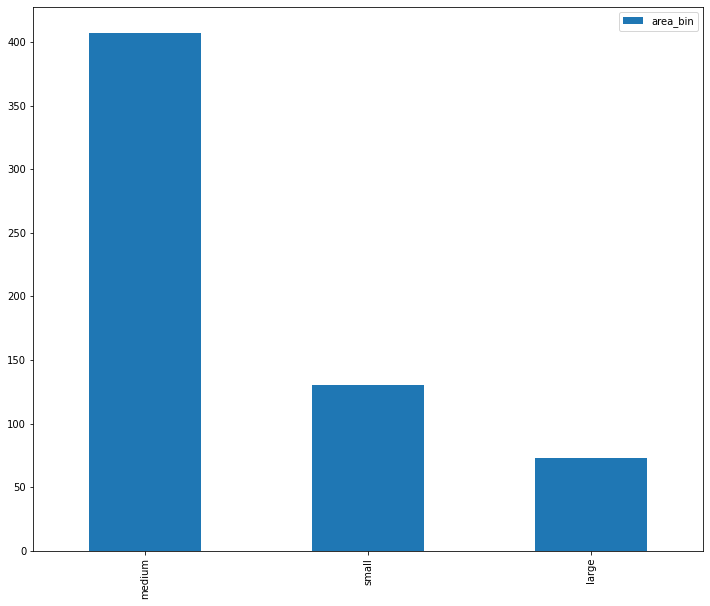

In [141]:
pd.DataFrame(df.area_bin.value_counts()).plot.bar()

array([[<AxesSubplot:title={'center':'large'}>,
        <AxesSubplot:title={'center':'medium'}>],
       [<AxesSubplot:title={'center':'small'}>, <AxesSubplot:>]],
      dtype=object)

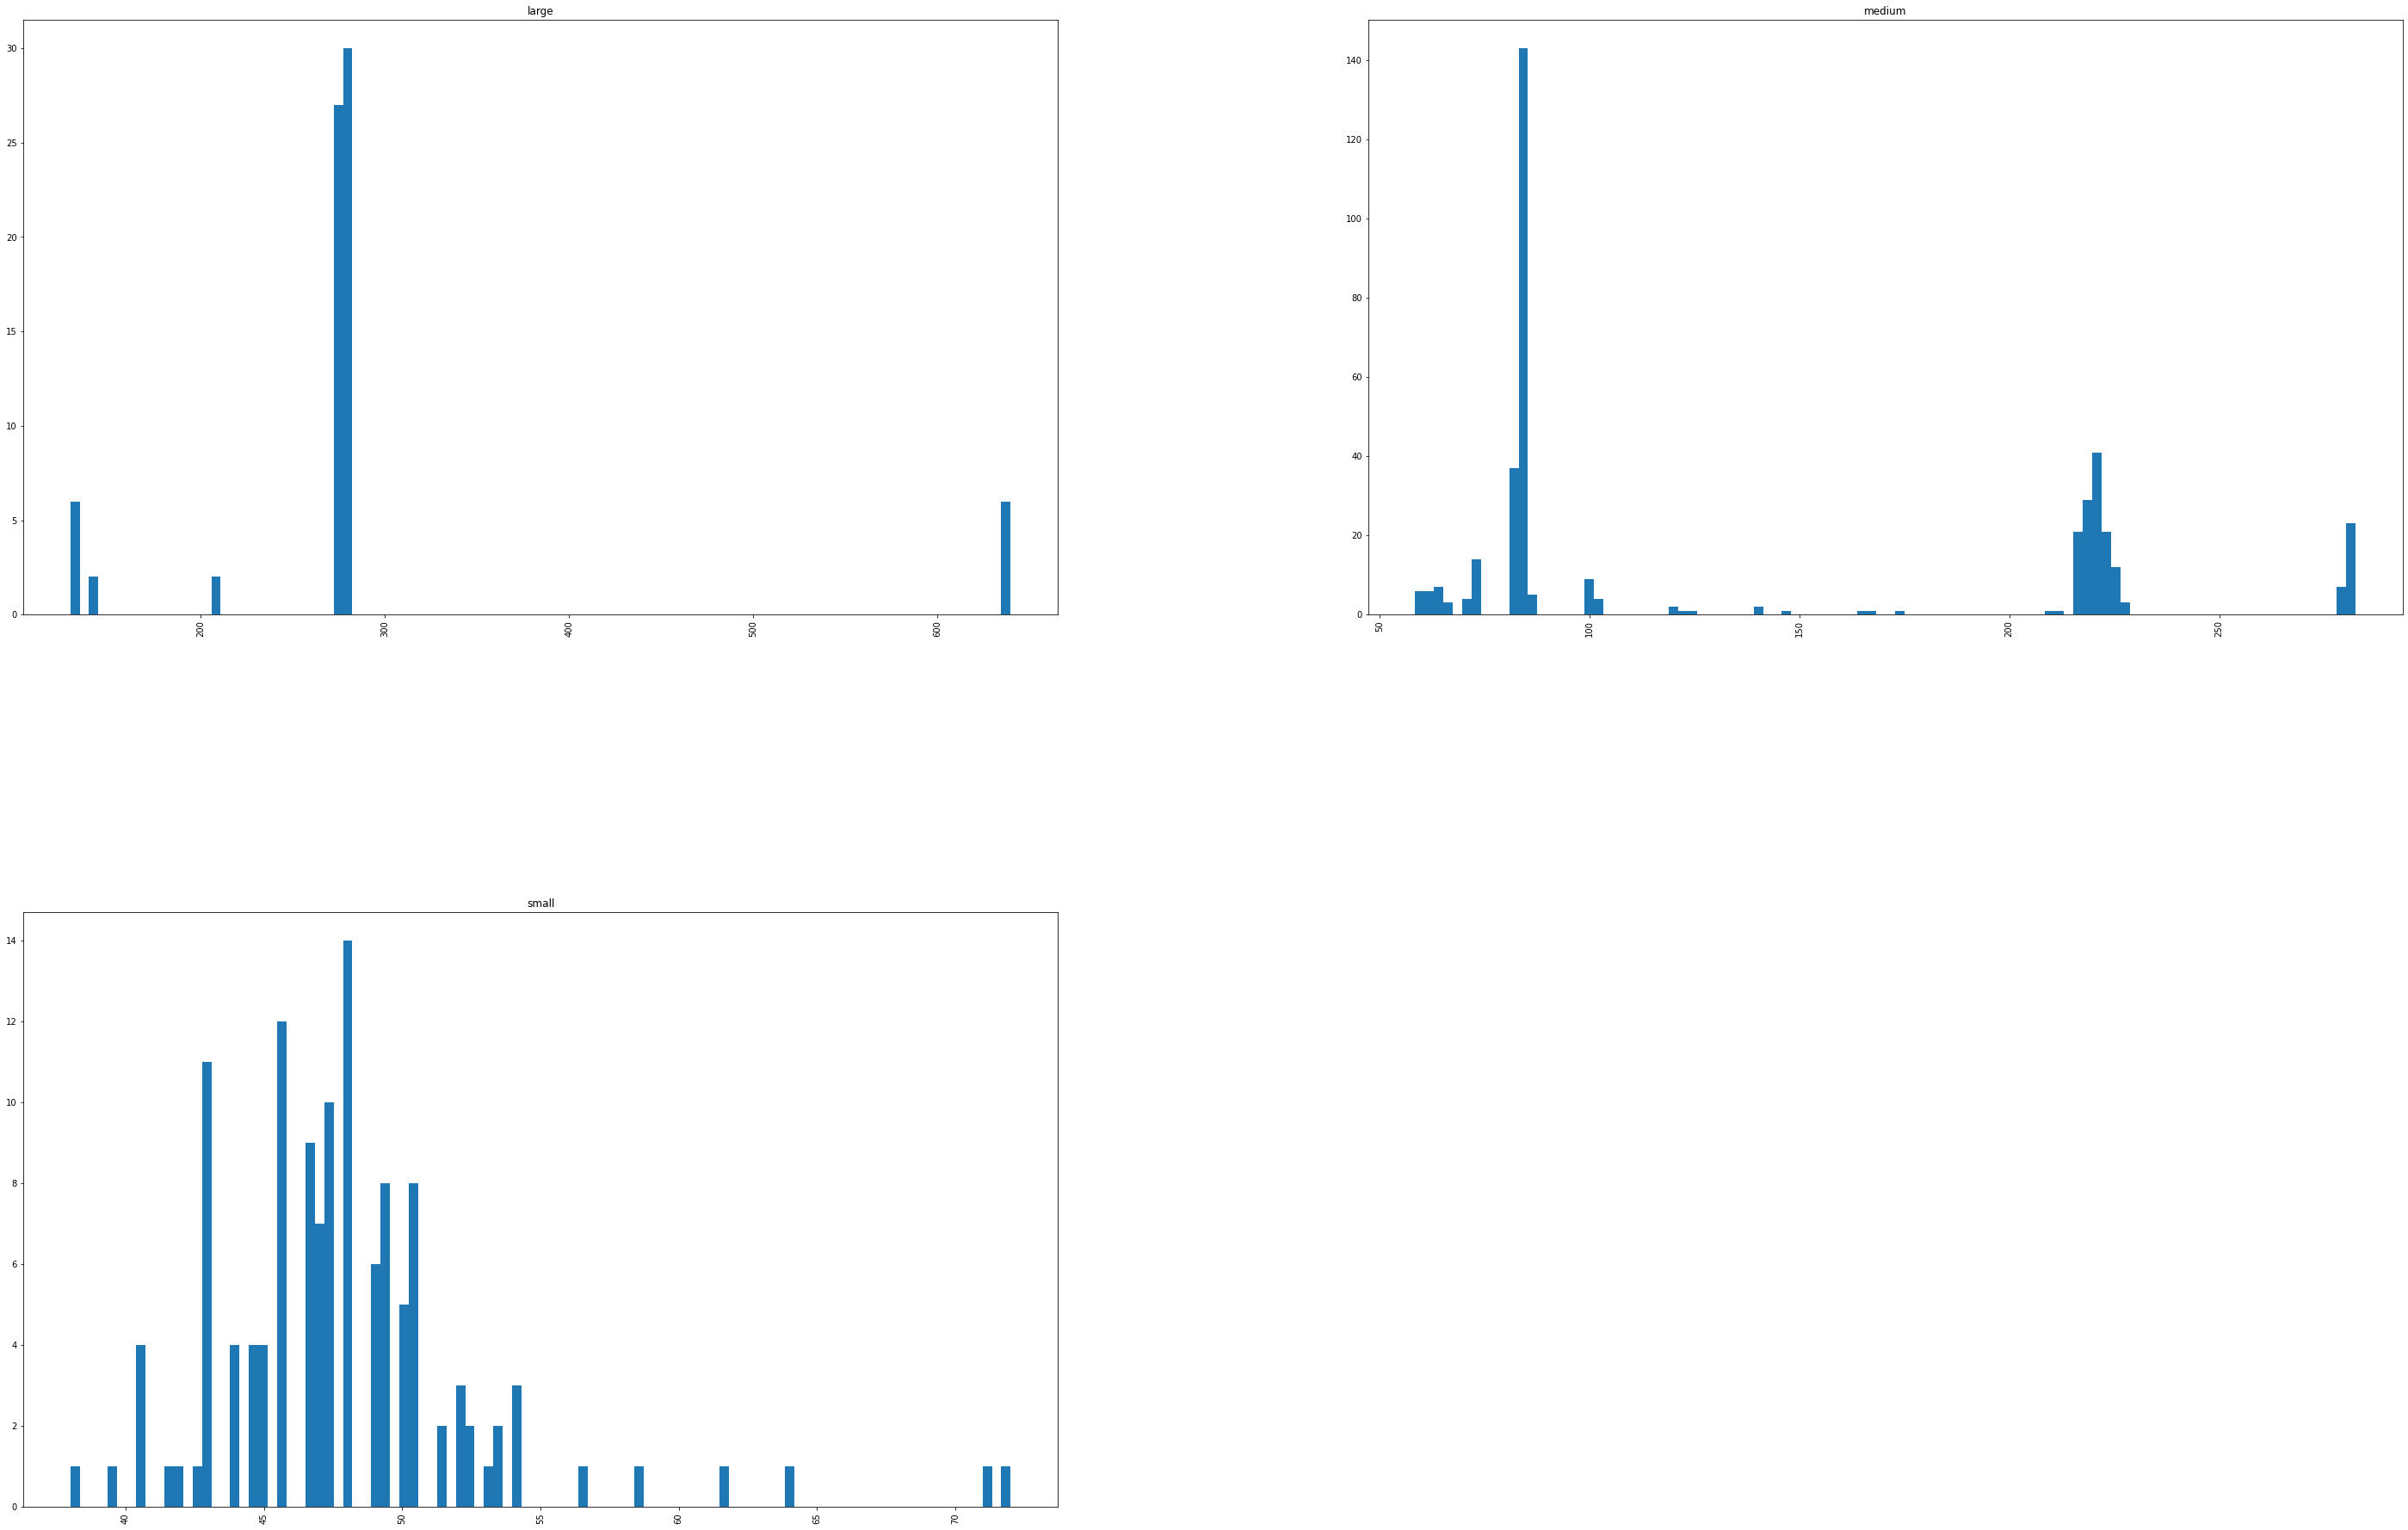

In [142]:
df.hist(column="width_scaled", bins=100, figsize=(48, 32), grid=True, by="area_bin")

array([[<AxesSubplot:title={'center':'large'}>,
        <AxesSubplot:title={'center':'medium'}>],
       [<AxesSubplot:title={'center':'small'}>, <AxesSubplot:>]],
      dtype=object)

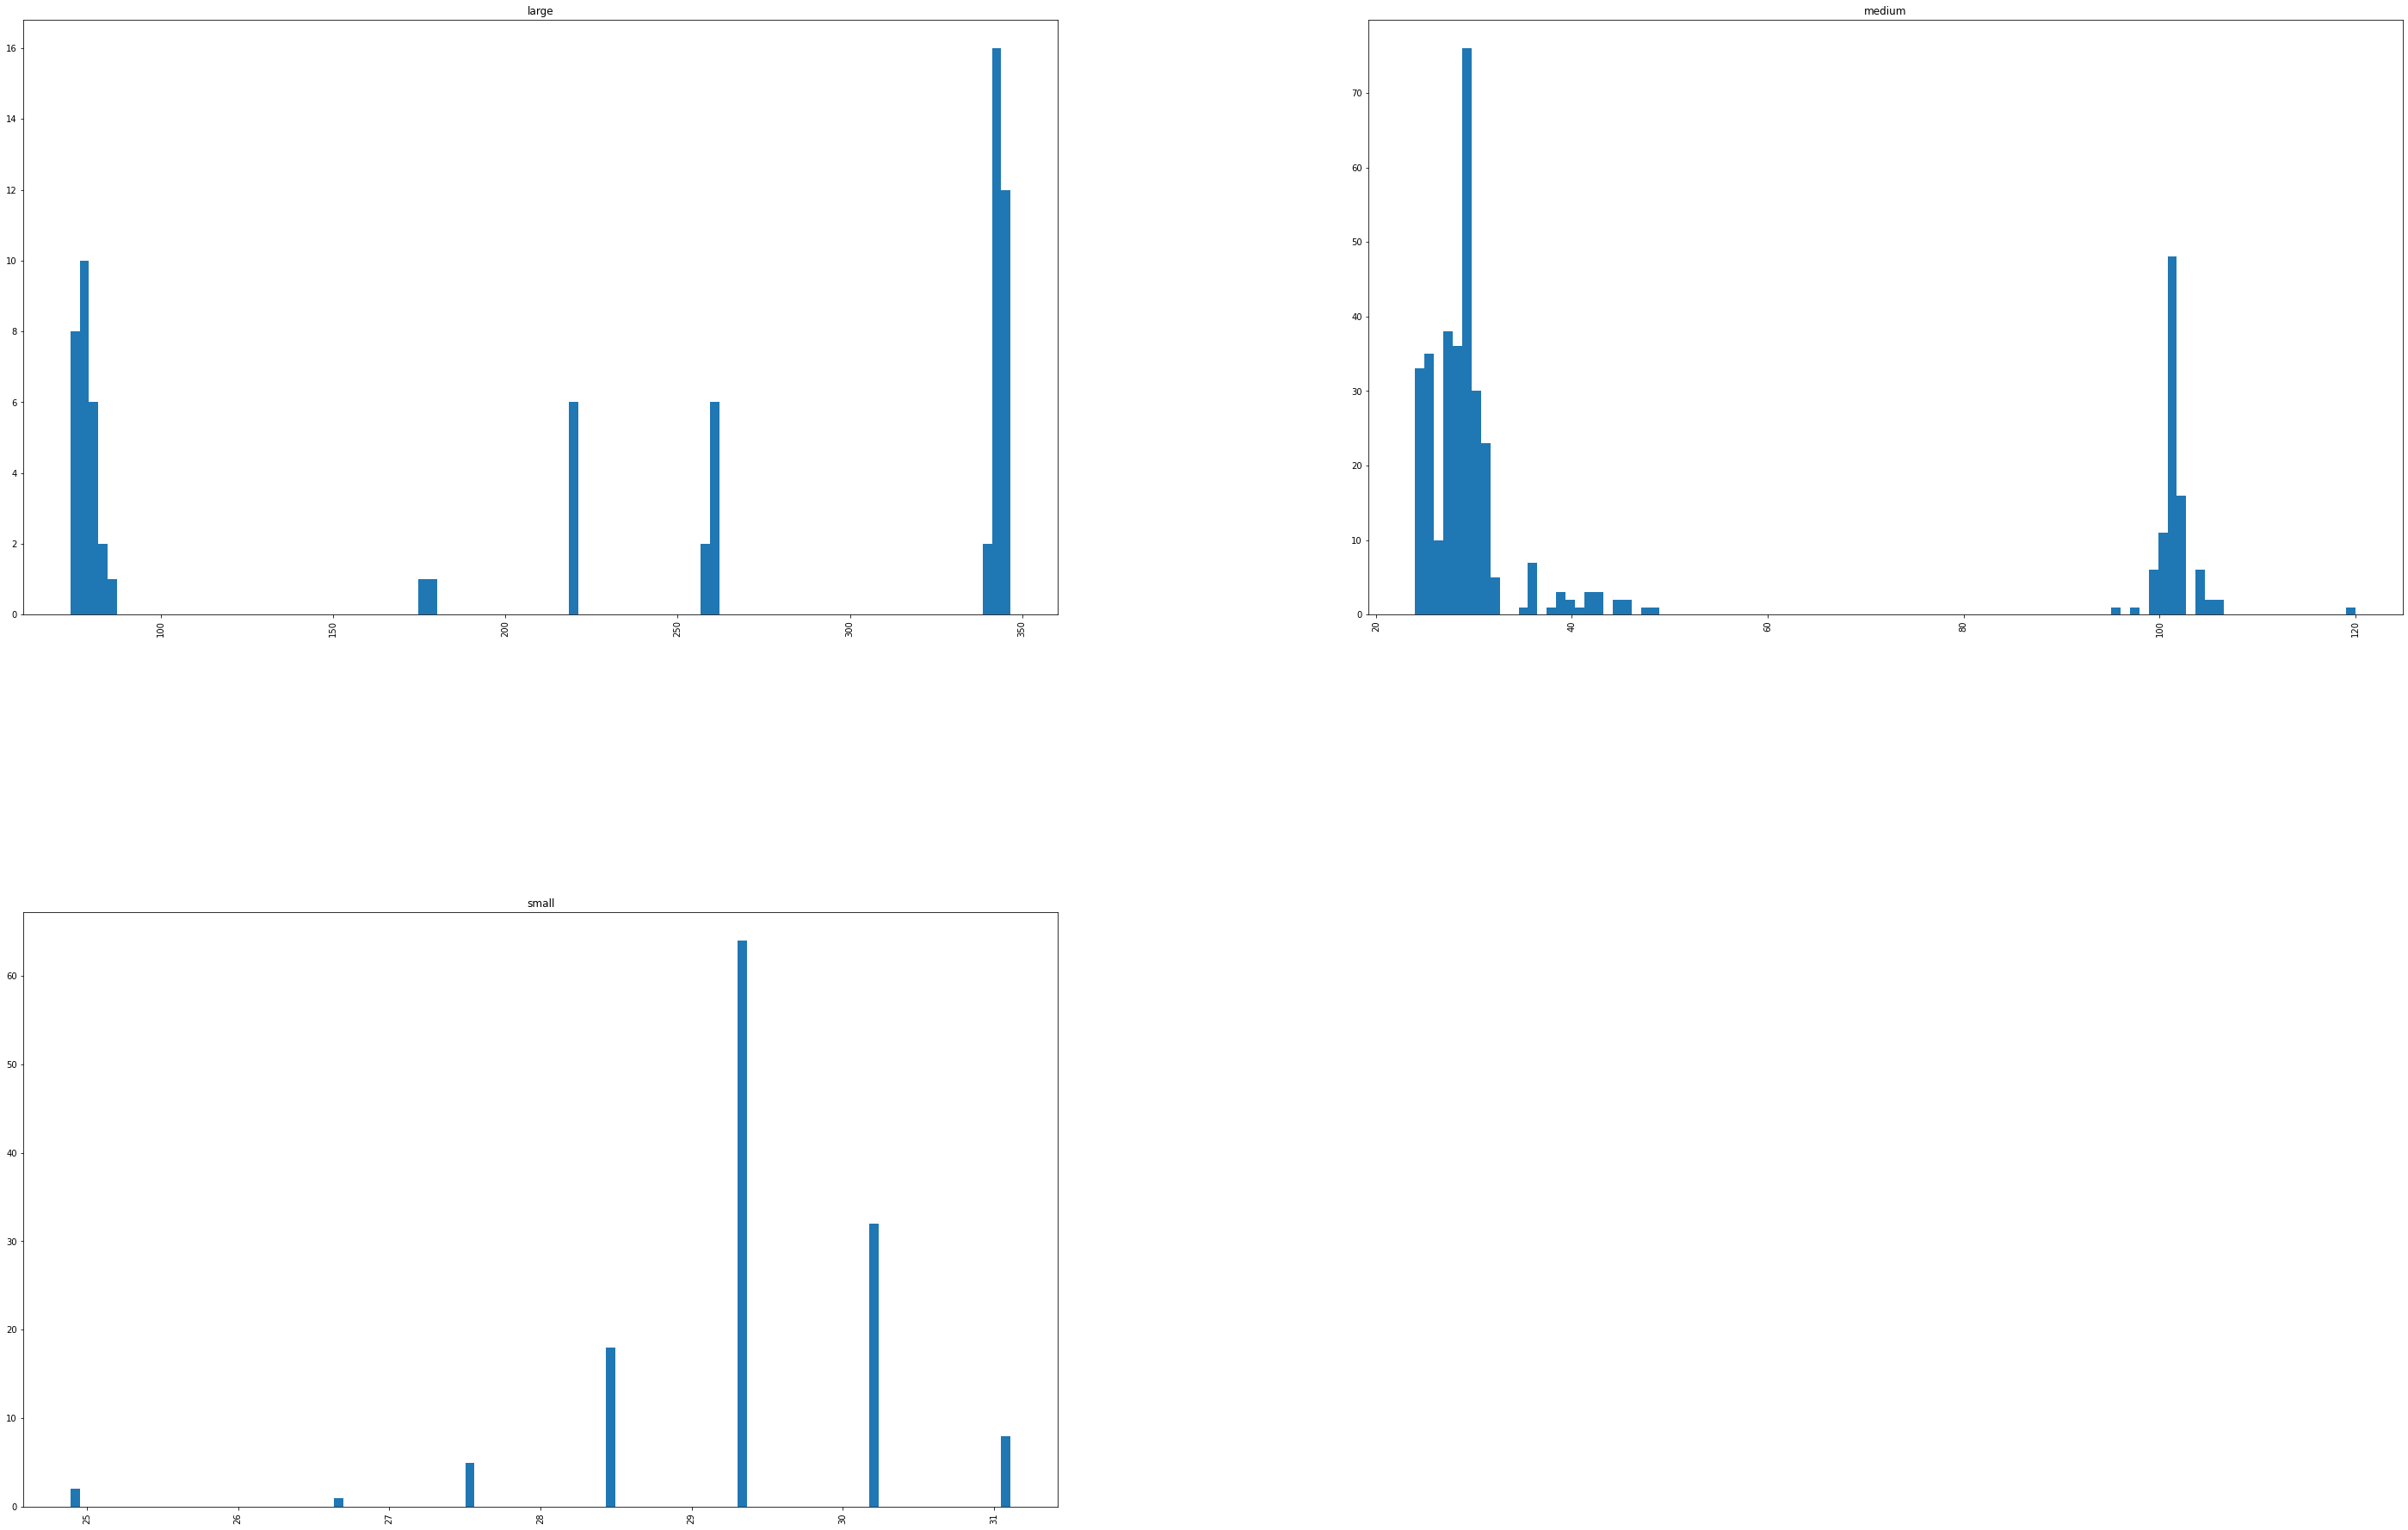

In [143]:
df.hist(column="height_scaled", bins=100, figsize=(48, 32), grid=True, by="area_bin")

array([[<AxesSubplot:title={'center':'large'}>,
        <AxesSubplot:title={'center':'medium'}>],
       [<AxesSubplot:title={'center':'small'}>, <AxesSubplot:>]],
      dtype=object)

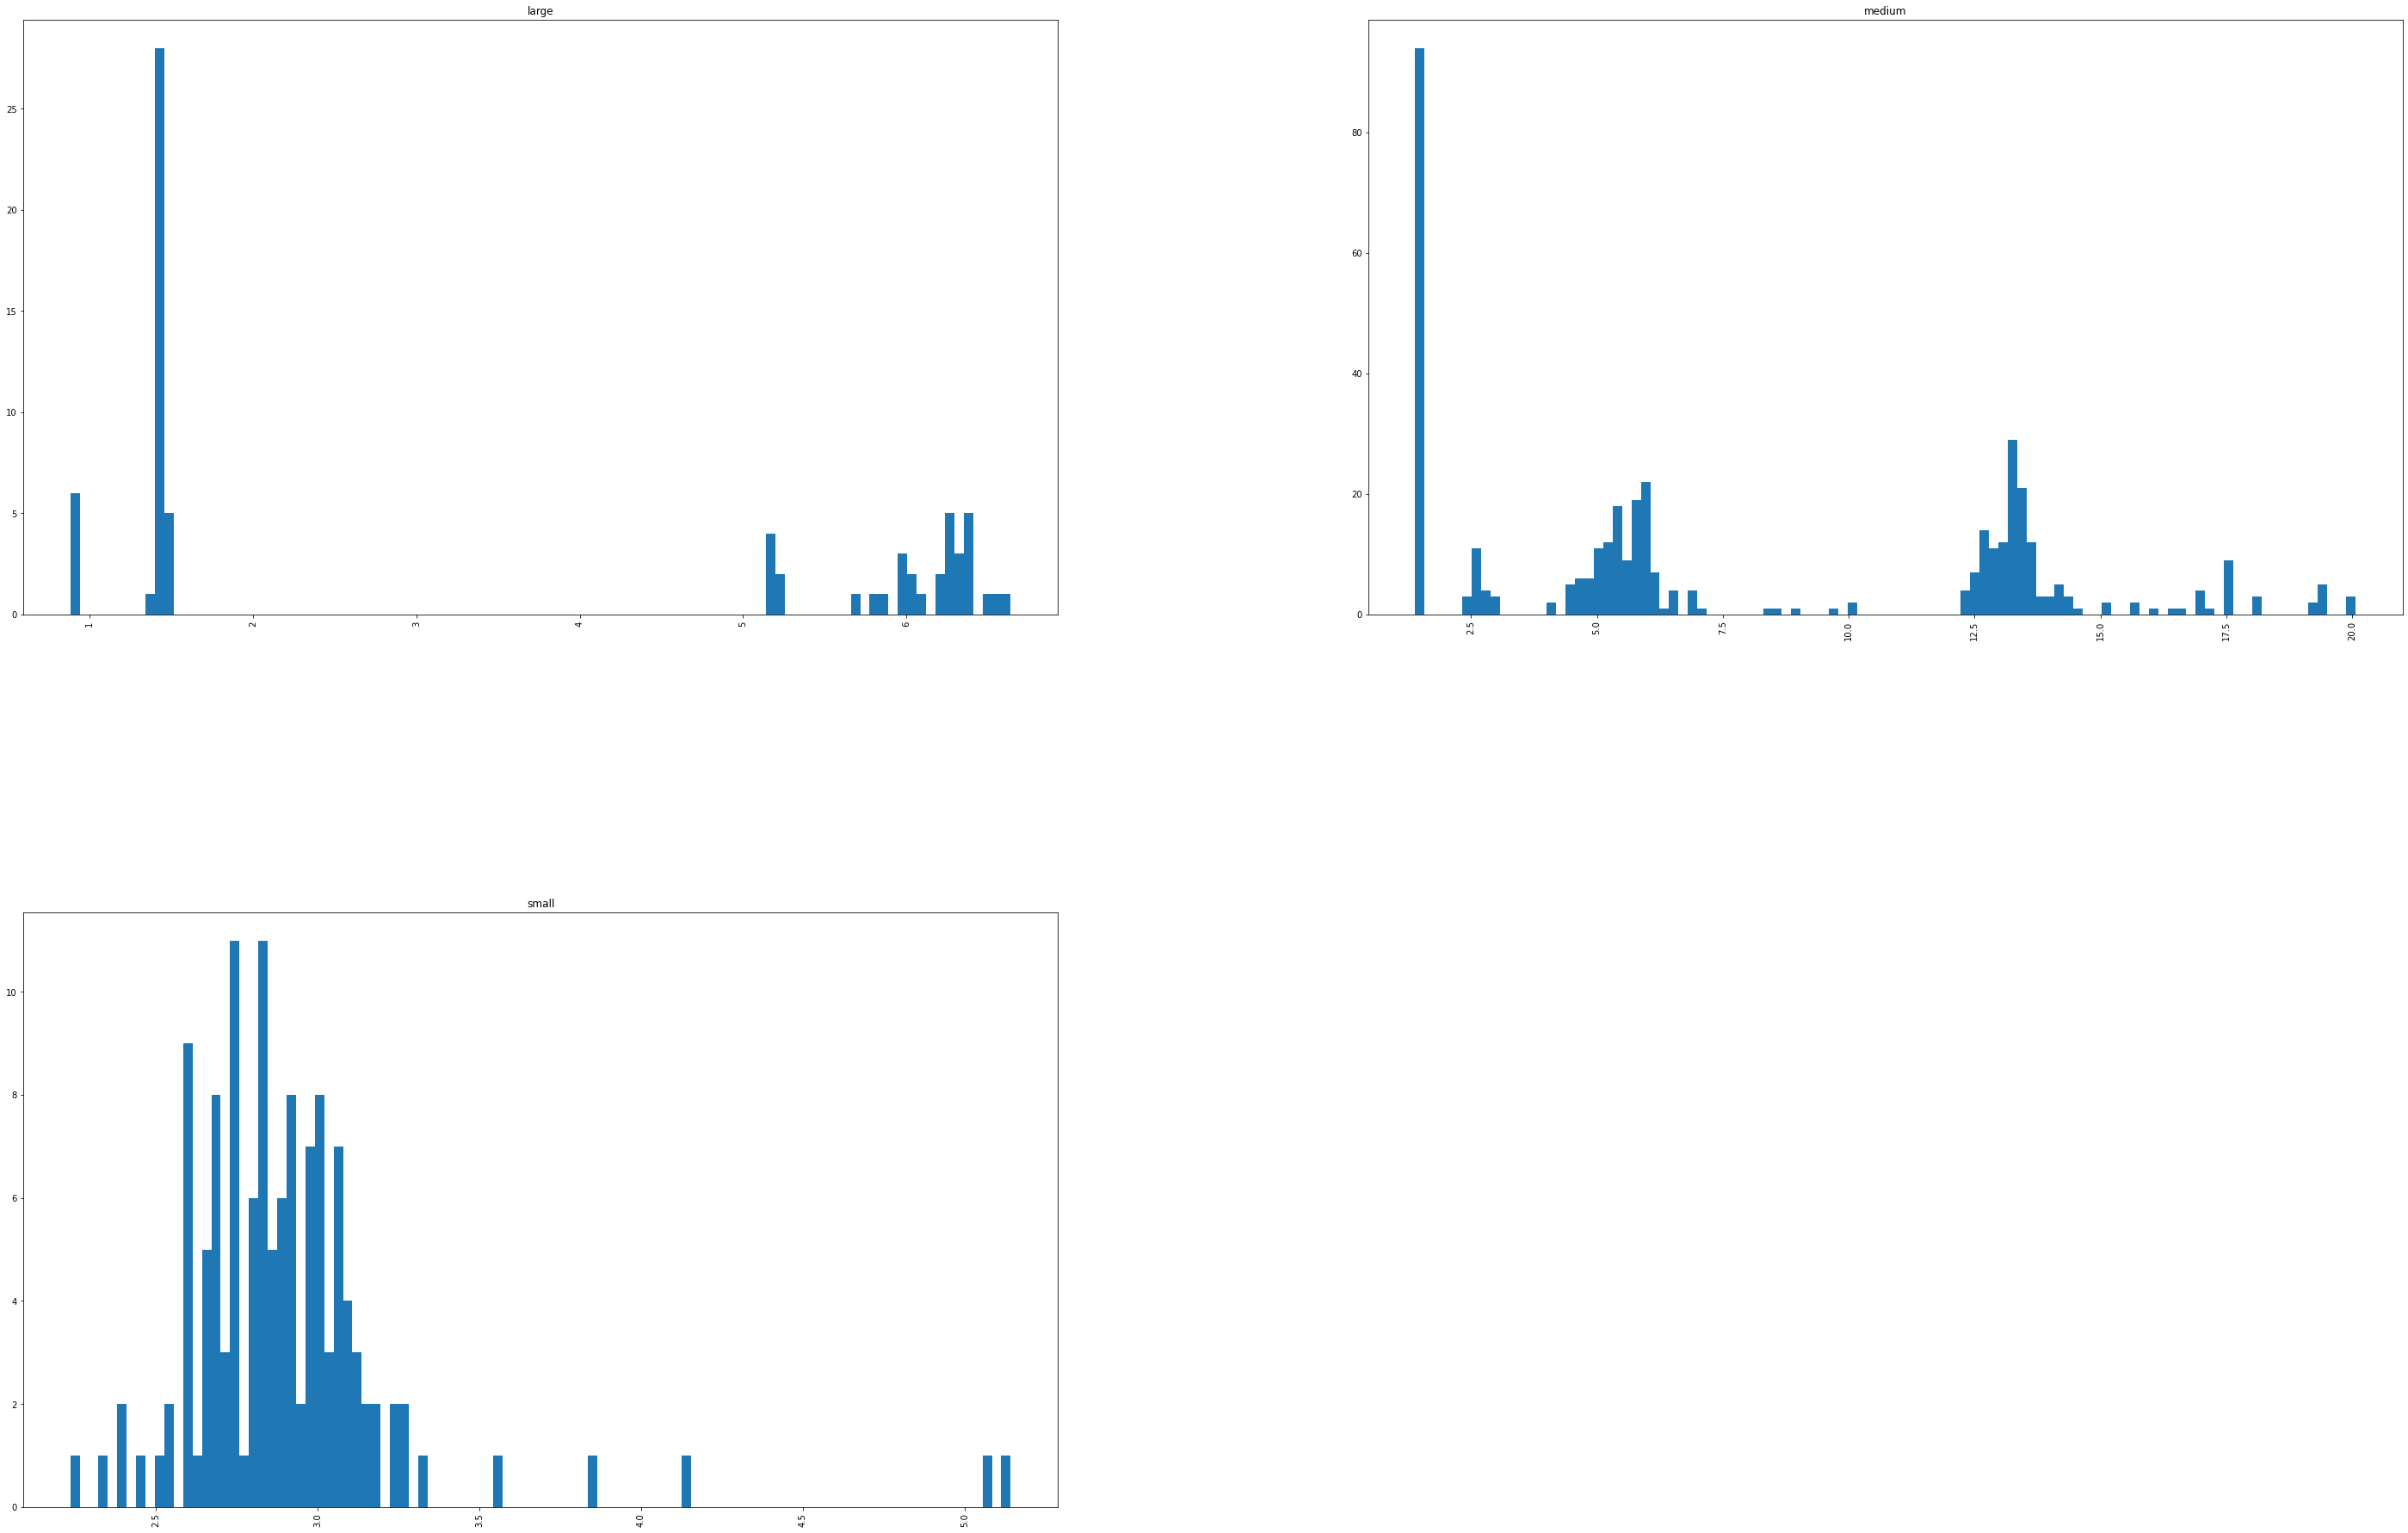

In [144]:
df.hist(column="ratio_wh", bins=100, figsize=(48, 32), grid=True, by="area_bin")

array([[<AxesSubplot:title={'center':'large'}>,
        <AxesSubplot:title={'center':'medium'}>],
       [<AxesSubplot:title={'center':'small'}>, <AxesSubplot:>]],
      dtype=object)

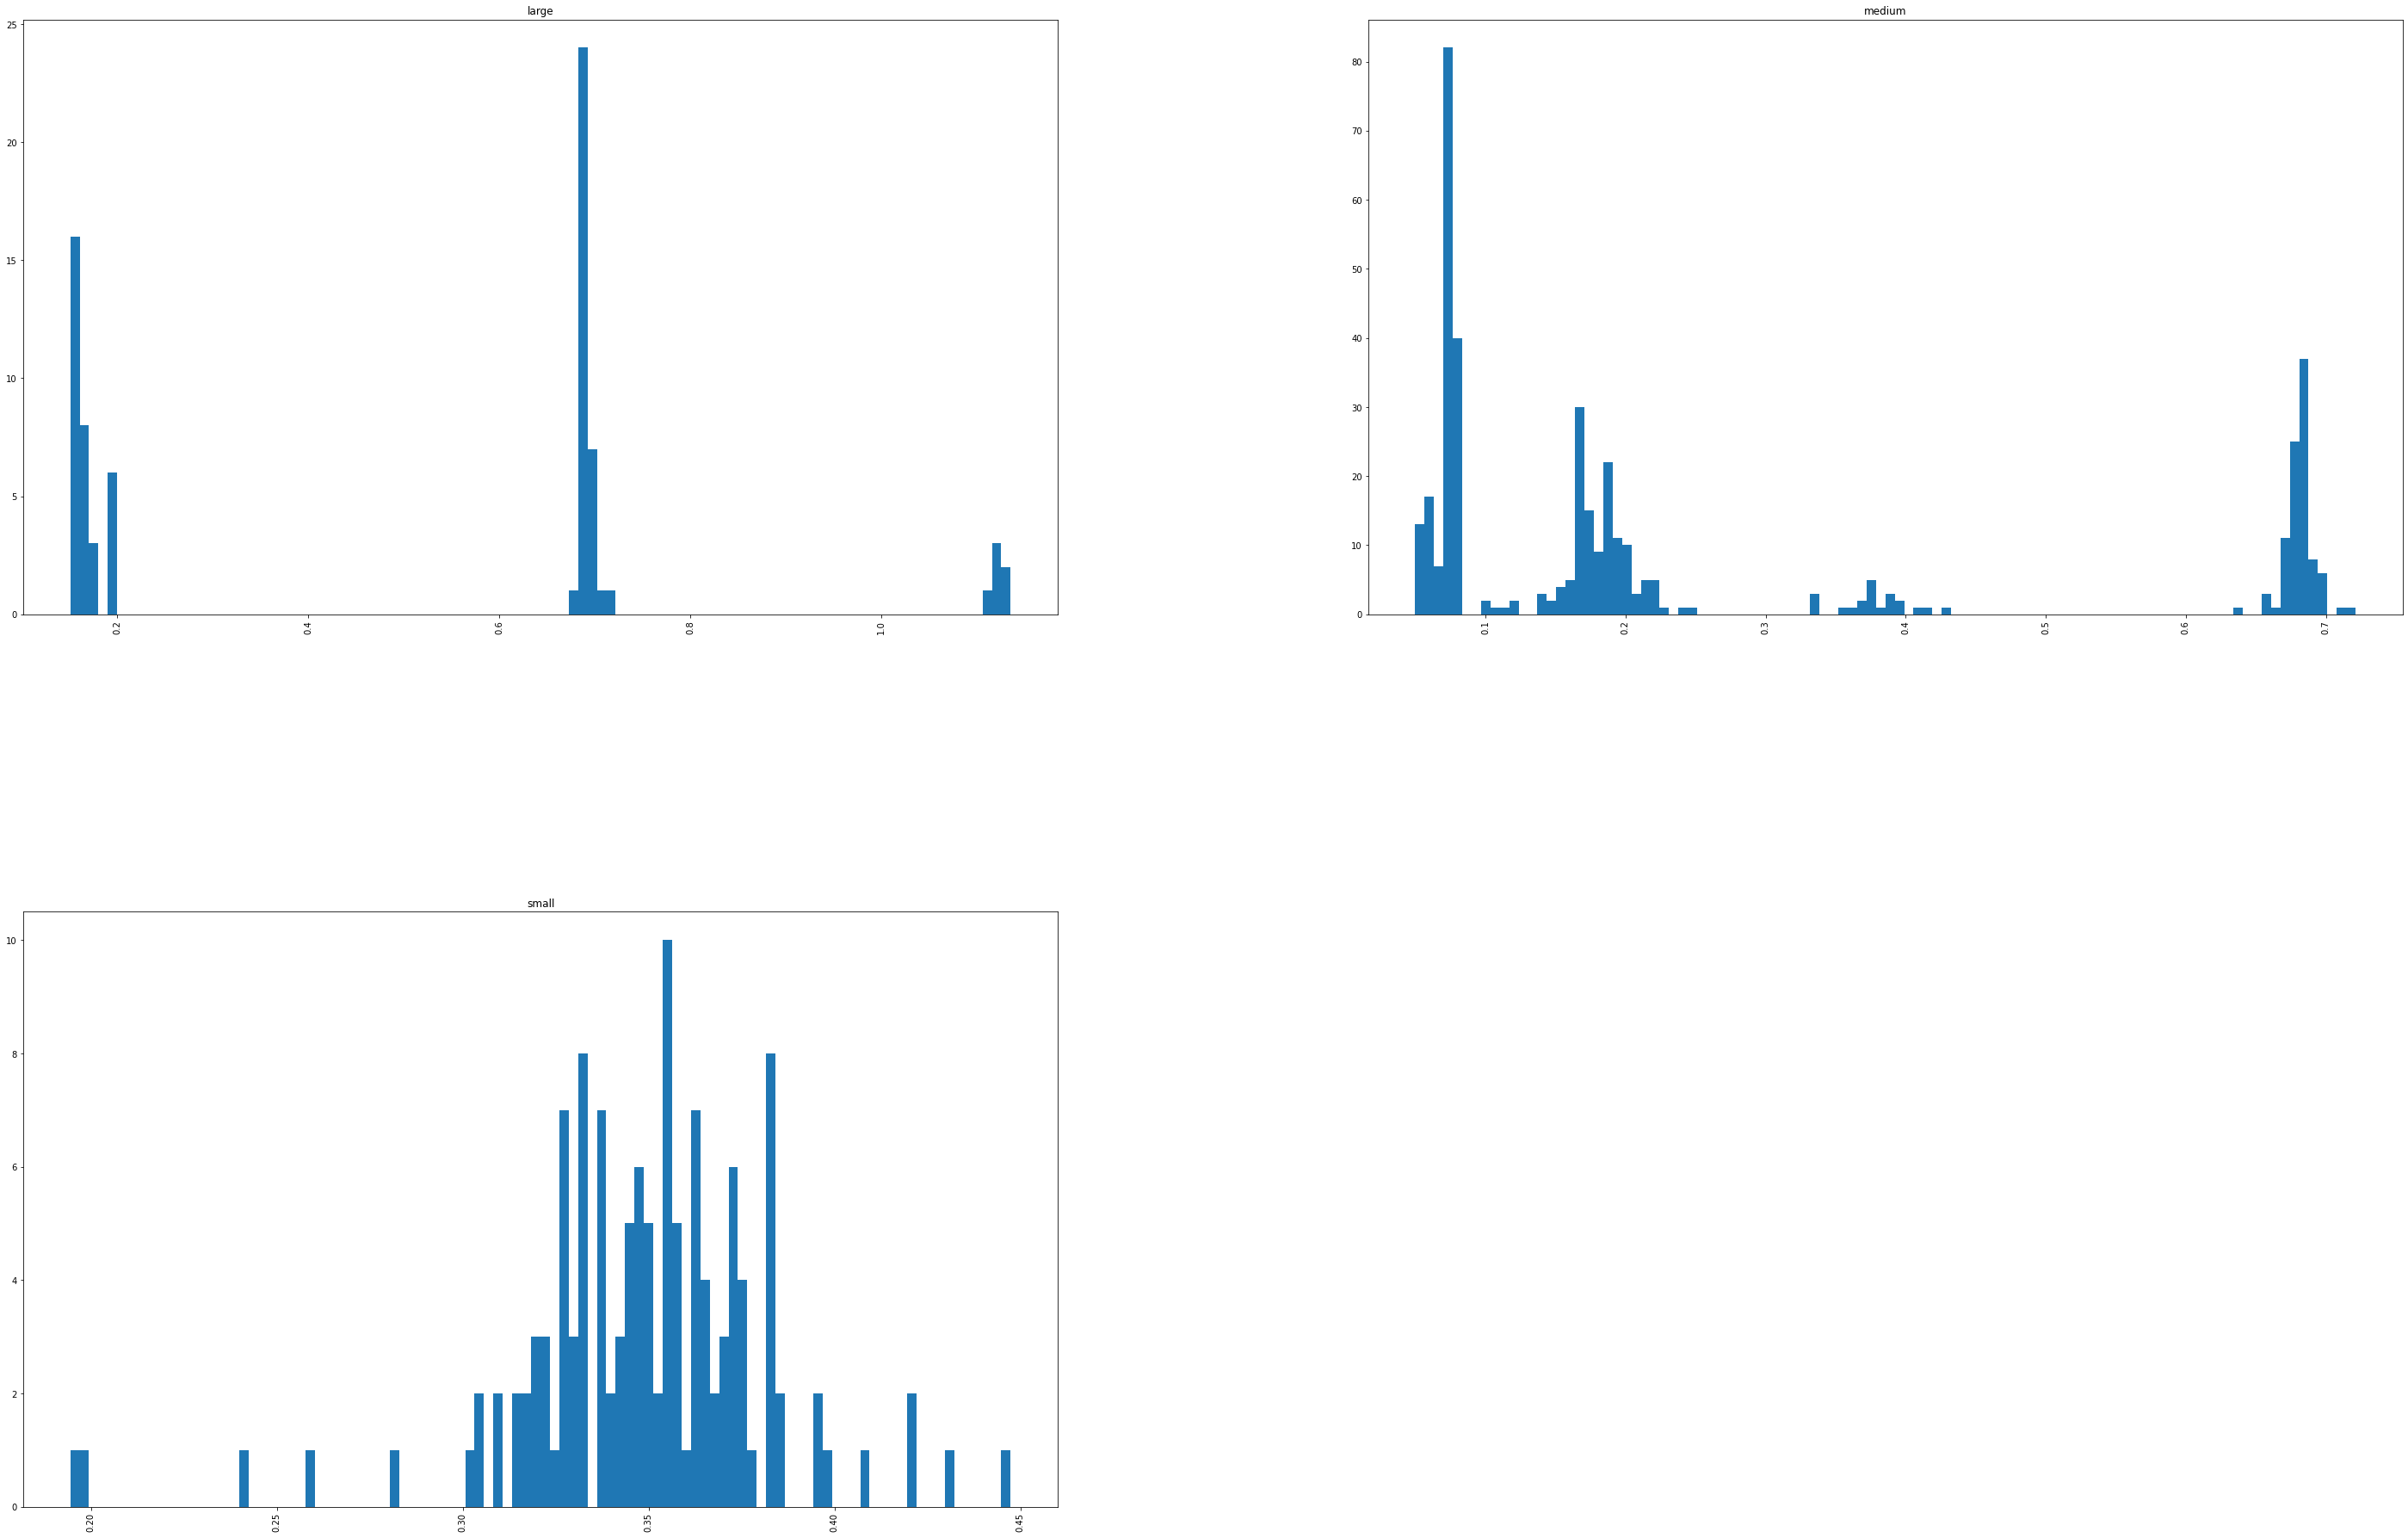

In [145]:
df.hist(column="ratio_hw", bins=100, figsize=(48, 32), grid=True, by="area_bin")

In [76]:
for img in tasks["images"]:
    # print(img)
    # print(img["file_name"].replace("/data/local-files/?d=", "/shared/gbiamby/geo/screenshots/"))
    img["file_name"] = img["file_name"].replace(
        "/data/local-files/?d=", "/shared/gbiamby/geo/screenshots/"
    )

json.dump(
    tasks,
    open(Path("/home/gbiamby/proj/geo/datasets/geoscreens_001/geoscreens_001.json"), "w"),
    indent=4,
    sort_keys=True,
)

In [62]:
tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [16, 32, 64, 128, 256])

((16, 20, 25), (32, 40, 50), (64, 80, 101), (128, 161, 203), (256, 322, 406))

In [63]:
anchor_sizes = tuple(
    (x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [32, 64, 128, 256, 512]
)
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
print(anchor_sizes, aspect_ratios)

((32, 40, 50), (64, 80, 101), (128, 161, 203), (256, 322, 406), (512, 645, 812)) ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))


### Train val Split

In [176]:
from collections import Counter

Counter([Path(img["file_name"]).parent.name for img in coco["images"]])

Counter({'aob8sh6l-6M': 160, 'DZ9JablpbhQ': 1})